## Imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import os
import glob
import copy
import statistics
# from scipy import stats 
from pylab import *
%matplotlib inline

## Read Dataframs

In [2]:
dataframes = [pd.read_csv(file, sep=',', index_col=0) for file in sorted(glob.glob('../preprocessed_datasets' + "/*."+'csv'))]
cohorts = [file.strip(".csv") for file in sorted(os.listdir('../preprocessed_datasets'))]

In [3]:
# make a dictionary containing cohort name and respective dataframe
all_cohorts = dict()
for name, df in zip(cohorts, dataframes):
    all_cohorts[name] = df.loc[df["Visit"] != 0]
    
    
all_cohorts_bl = dict()
for name, df in zip(cohorts, dataframes):
    all_cohorts_bl[name] = df.loc[df["Visit"] == 1]

### Number of Patients with More Than 2 Visits  and Visit Intervals Approximately

In [4]:
def follow_up(dfs, result):
    """ Compute the number of participants with more than 2 visits and visit intervals """
    
    for cohort in dfs:
        
        if cohort!= 'EPAD':
            df = dfs[cohort]
            result.loc[cohort, '2+ visits'] = len([x for x in Counter(df.index).values() if x > 1])

            if df.index.is_unique:
                result.loc[cohort, 'Follow-up Interval'] = 'no follow-up'

            else:
                mo = sorted(list(Counter(df.loc[df['Months'].notna(), 'Months'])))
                interval = statistics.mode(np.diff(mo))
                result.loc[cohort, 'Follow-up Interval'] = interval
        
        elif cohort=='EPAD':
            df = dfs[cohort]
            result.loc[cohort, '2+ visits'] = len([x for x in Counter(df.index).values() if x > 1])
            result.loc[cohort, 'Follow-up Interval'] = 12

    return result

### Total Number of Participants and Per Diagnostic Group

In [5]:
def cat_stat_df(dfs, result):
    """Counting different diagnosis, total number of participants and store results in a df"""
    
    categorical = {'Diagnosis': ['CU', 'MCI', 'AD']}
    column_cat = ['Diagnosis']
    diags = ['CU', 'MCI', 'AD']

    for cohort in dfs:
        
        if dfs[cohort].empty==True:
            continue
        
        else:
            calc_dict = dict()
            df = dfs[cohort]

            for col in column_cat:
                ca = Counter(df[col].dropna())
                calc_dict[col] = ca

            cohort_df = pd.DataFrame(calc_dict).transpose()
            cohort_df = cohort_df.dropna(how='all')            
        
        if cohort_df.empty!=True:
            
            for i in diags:
                
                if i in cohort_df.columns:
                    result.loc[cohort, i] = cohort_df.loc['Diagnosis', i]
                    
                else:
                    result.loc[cohort, i] = 0
            
        result.loc[cohort, 'Total'] = len(df.index.unique())
              
    return result

In [6]:
# define a empty dataframe to store the result
results = pd.DataFrame(index = all_cohorts.keys(), columns = ['2+ visits', 'Follow-up Interval', 'CU', 'MCI', 'AD', 'Total'])
results.index.name = 'Name of Dataset'

results = follow_up(all_cohorts, results)
results = cat_stat_df(all_cohorts_bl, results)
results.to_csv("../adata_resources/cohort_description.csv")
results

,2+ visits,Follow-up Interval,CU,MCI,AD,Total
Name of Dataset,,,,,,
A4,0,no follow-up,6945,0,0,6945
ABVIB,227,12.0,NaN,NaN,NaN,280
ADNI,1977,6,813,1016,389,2249
AIBL,1019,18.0,803,134,181,1378
ANM,1262,12.0,793,397,512,1703
ARWIBO,80,12,1476,208,281,2617
DOD-ADNI,458,12.0,181,27,0,458
EDSD,0,no follow-up,183,140,151,474
EMIF,0,no follow-up,366,526,201,1199


In [7]:
print('Total number of participants: ', sum(results['Total']))

Total number of participants:  66807


###  Number of Patients Per Visit (Normalized)

In [8]:
def norm_visits(dfs, col_nam, result):
    """"""
    
    for study_n in all_cohorts:
        df = all_cohorts[study_n]
        df_n = pd.DataFrame(df[col_nam])
        df_n['Cohort'] = study_n

        # check how many patients there are at baseline
        total_patient = len(df_n[df_n[col_nam]==0])
        visit_dic = [Counter(df_n[col_nam])]

        dfnn = pd.DataFrame(visit_dic).transpose()
        dfnn.rename(columns={0: 'Patients'}, inplace=True)
        dfnn['Cohort'] = study_n
        dfnn.index.name = col_nam 
        norm_val = []

        for i in dfnn['Patients']:
            norm_val.append(round( i/total_patient, 3))

        dfnn['Normalized'] = norm_val
        result = result.append(dfnn)
        
    result.index.astype(float)
    result.index.name = col_nam
    result = result.sort_index()
    result = result[result.index.notnull()]
    
    return result

In [9]:
# make an empty dataframe to store the results 
all_visits = pd.DataFrame(columns = ['Patients', 'Cohort', 'Normalized'])

all_visits = norm_visits(all_cohorts, 'Months', all_visits)

In [10]:
# extract the Hex value of color platte "Set1"
cmap = cm.get_cmap('Set1', 9)

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    #print(matplotlib.colors.rgb2hex(rgba))

#print('**********************')

# extract the Hex value of color platte "Set3"
cmap2 = cm.get_cmap('Set3', 12)

for i in range(cmap2.N):
    rgba = cmap2(i)
    # rgb2hex accepts rgb or rgba
    #print(matplotlib.colors.rgb2hex(rgba))

## Barplot

In [11]:
def long_plot(input_df, plot, title, mark_bl=False, fig_size=[15,8], feat=None):
    
    sns.set_style("ticks")
    
    # prepare new plotting dataframe to avioid changes to the original one
    plotdf = input_df.copy()
    plotdf['Year'] = plotdf.index / 12
    plotdf["Normalized"] = plotdf["Normalized"]*100
    
#     colors = {'A4': "#17becf", 'ANMerge': '#377eb8', 'ARWIBO': '#8dd3c7', 'EDSD': '#ffffb3', 'EMIF': '#a65628', 
#               'EPAD': '#4daf4a', 'Emory_Vascular': '#bebada', 'AIBL': '#ff7f00', 'I-ADNI': '#fb8072', 
#               'NACC': '#984ea3', 'OASIS': '#80b1d3', 'PREVENT-AD': '#fdb462', 'PharmaCog': '#b3de69', 
#               'ROSMAP': '#f781bf', 'VITA': '#fccde5', 'JADNI': '#999999', 'ADNIDOD': '#d9d9d9', 
#               'WMH-AD': '#bc80bd', 'ADNI': '#e41a1c', 'ABVIB': '#ccebc5'}

    colors = {'ADNI': '#d62728', 'ANM': '#1f77b4', 'AIBL': '#ff7f0e', 'EPAD': '#2ca02c', 
          'NACC': '#9467bd', 'EMIF': '#8c564b', 'ROSMAP': '#e377c2', 'JADNI': '#7f7f7f', 
          'A4': '#aec7e8', 'DOD-ADNI': '#ffbb78', 'PREVENT-AD': '#98df8a', 'ARWIBO': '#ff9896', 
          'I-ADNI': '#c5b0d5', 'EDSD': '#c49c94', 'OASIS': '#f7b6d2', 'PharmaCog': '#c7c7c7', 
          'VITA': '#bcbd22', 'WMH-AD': '#dbdb8d', 'VASCULAR': '#9edae5', 'ABVIB': '#e0d9e2'}
    
    # delete all datasets from legend that have no associated data
    color_keys = pd.Series(list(colors.keys()))
    not_available = color_keys[~color_keys.isin(plotdf["Cohort"])]
    for dataset in not_available:
        del colors[dataset]
    
    # get datsets which only have baseline
    long_bool = plotdf["Cohort"].loc[0].isin(plotdf["Cohort"].drop(0, axis=0))
    bl_only = plotdf["Cohort"].loc[0][~long_bool]
    
    plt.figure(figsize=fig_size)
    
    # add markers for baseline values if no longitudinal are available
    if mark_bl: 
        for dataset in bl_only:
            plt.plot([0], list(plotdf[plotdf["Cohort"]==dataset]["Normalized"]), 
                     "o", color=colors[dataset])
    else: # Otherwise delete them from colors to avoid showing up in the legend
        for dataset in bl_only:
            del colors[dataset]
    
    if plot=="line":
        ax = sns.lineplot('Year', 'Normalized', hue="Cohort", hue_order=sorted(colors.keys()), 
                     palette=colors, data=plotdf, marker="o")
    elif plot=="bar":
        ax = sns.barplot('Year', 'Normalized', hue="Cohort", hue_order=sorted(colors.keys()), 
                     palette=colors, data=plotdf) 
        
    leg = plt.legend(title="Cohorts", loc='upper right')
    plt.title(title, fontweight="bold", fontsize=22)
    plt.xlabel("Year in Study", fontweight="bold", fontsize=19)
    plt.ylabel("Baseline participants (%)", fontweight="bold", fontsize=19)
    plt.ylim(0, 105)
    plt.xlim(-0.3, 26.5)

    plt.setp(ax.lines,linewidth=2,alpha=.8)
                      
    # prepare legend
    plt.setp(ax.get_legend().get_texts(), fontsize='18') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='1') # for legend title
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4)
    
    # prepare ticks
    plt.xticks(ticks=range(0, 27), labels=range(0, 27))
    ax.tick_params(labelsize=20)
    
    if feat:
        plt.savefig('../Figures/'+feat+'_'+plot+'_long_plot.png', format='png', dpi=300)

/home/ysalimi/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


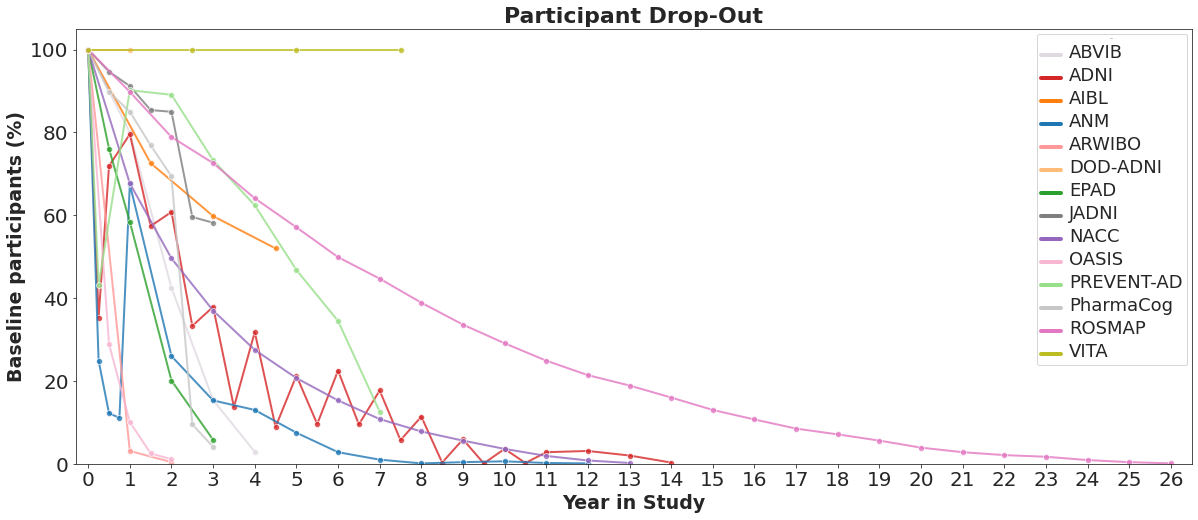

In [12]:
long_plot(all_visits, "line", title="Participant Drop-Out", fig_size=[20, 8], feat='all')

# longitudinal follow up of biomarkers

### Create resources for longitudinal BM plots on AData

In [13]:
rel_cols = ['CDR', 'MMSE', 'CDRSB', 'Hippocampus', 'Ttau', 'Ptau', 'A-beta']

for feat in rel_cols:

    featdf = pd.DataFrame(columns=["Counts", "Normalized", "Cohort"])

    #for dataset, name in zip(datasets, names):
    for cohort in all_cohorts:
        dataset = all_cohorts[cohort]
        n = len(dataset[dataset["Months"]==0]) # for normalization, get number of patients

        # create a dataframe to which we add study results
        try:
            counts = pd.Series(Counter(dataset[[feat, "Months"]].dropna()["Months"]), dtype='float64')
            
        except KeyError:
            continue

        results = pd.DataFrame(counts, columns=["Counts"])

        # add new colums
        results["Normalized"] = round(results["Counts"] / n, 3)
        results["Cohort"] = cohort

        featdf = pd.concat([featdf, results])

    featdf.index.cohort = 'Months'
    featdf = featdf.sort_index()
    featdf.to_csv("../adata_resources/bm_follow_up/"+feat+"_bm_longitudinal.csv")

    if feat == "A-beta":
        abeta = featdf
    elif feat == "MMSE":
        mmse = featdf

/home/ysalimi/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


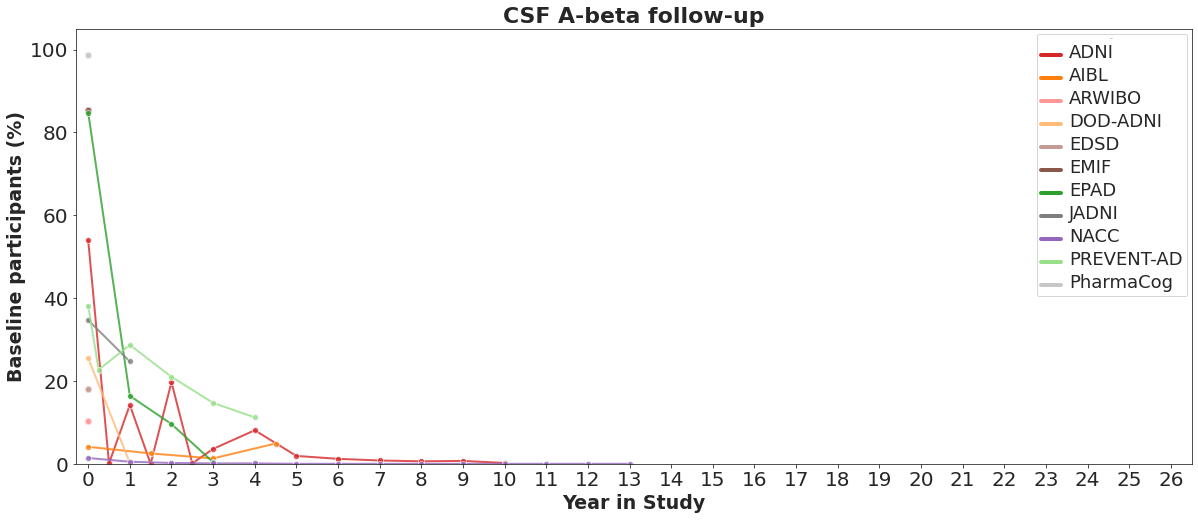

In [14]:
# create example plot for A-beta
long_plot(abeta, "line", "CSF A-beta follow-up", True, fig_size=[20,8], feat="abeta")

/home/ysalimi/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


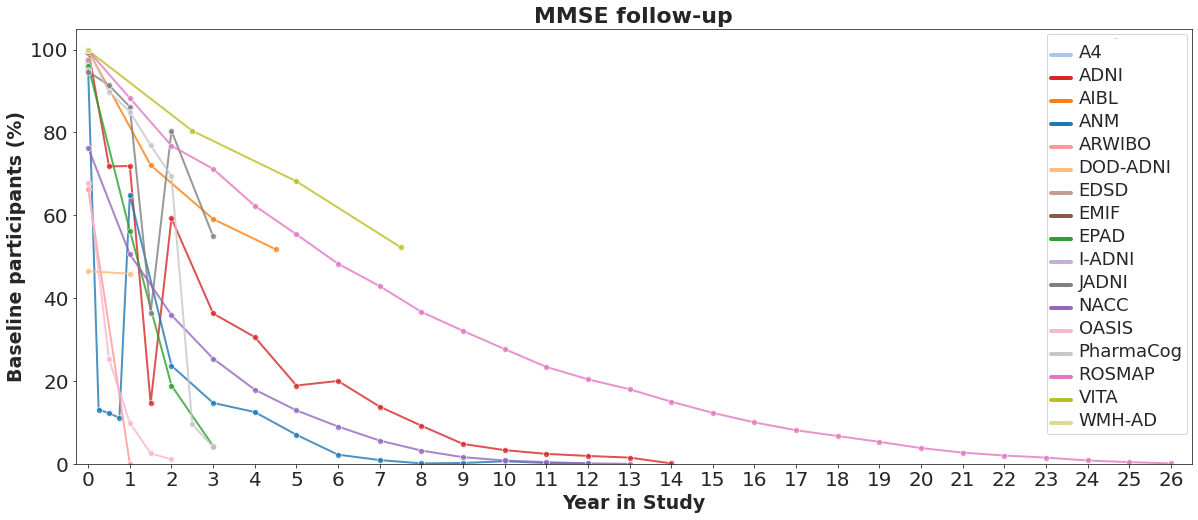

In [15]:
# create example plot for A-beta
long_plot(mmse, "line", "MMSE follow-up", True, fig_size=[20,8], feat="mmse")

In [16]:
## take times 100 cause Daniel wants it
all_visits.rename(columns={"patients":"Patients"}, inplace=True)
all_visits.to_csv("../adata_resources/normalized_longitudinal_follow_up.csv")